Uso de la data loan200, que muestra los records de prestamos personales de Lending Club. \
El análisis se centrará en predecir si el prestamo sera "paid off"[deuda saldada] o "default"[incumpliento de deuda] por los nuevos clientes.

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from category_encoders.target_encoder import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real,Categorical, Integer

In [136]:
loan_data = pd.read_csv('loan_data.csv')
# loan_data.head()
print(loan_data.columns)
# print(loan_data.info())


Index(['Unnamed: 0', 'status', 'loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 'purpose',
       'home_ownership', 'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'outcome', 'emp_length', 'purpose_', 'home_', 'emp_len_',
       'borrower_score'],
      dtype='object')


In [137]:
predictores = ['loan_amnt','annual_inc','payment_inc_ratio','purpose_','home_','emp_len_','borrower_score']
loan_data['outcome'] = loan_data['outcome'].apply(lambda x:0 if x == 'default' else 1)

y = loan_data['outcome']

X = loan_data[predictores]
X.head()


,loan_amnt,annual_inc,payment_inc_ratio,purpose_,home_,emp_len_,borrower_score
0,2500,30000,2.39320,major_purchase,RENT,> 1 Year,0.65
1,5600,40000,4.57170,small_business,OWN,> 1 Year,0.80
2,5375,15000,9.71600,other,RENT,> 1 Year,0.60
3,9000,30000,12.21520,debt_consolidation,RENT,> 1 Year,0.50
4,10000,100000,3.90888,other,RENT,> 1 Year,0.55


In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2,stratify=y, random_state=1)

In [139]:
# Se establece el Pipeline
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=1,objective='binary:logistic'))
    ]
mi_pipe = Pipeline(steps=estimators)
print(mi_pipe)

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                             

In [140]:
# afinando los hyperparametros de XGBoost para obtener mejores resultado del modelo
params_space = {
    'clf__max_depth': Integer(2,8),
    'clf__n_estimators': Integer(1, 250),
    'clf__learning_rate': Real(0.001,1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5,1.0),
    'clf__colsample_bylevel':Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5,1.0),
    'clf__reg_alpha': Real(0.0,10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

model_tuned = BayesSearchCV(mi_pipe, params_space, cv=3, n_iter=10, scoring='roc_auc',random_state=1)



In [141]:
model_tuned.fit(X_train,y_train)

,estimator,"Pipeline(step...=None, ...))])"
,search_spaces,"{'clf__colsample_bylevel': Real(low=0.5,...m='normalize'), 'clf__colsample_bynode': Real(low=0.5,...m='normalize'), 'clf__colsample_bytree': Real(low=0.5,...m='normalize'), 'clf__gamma': Real(low=0.0,...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,10
,scoring,'roc_auc'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [142]:
print(model_tuned.best_estimator_)

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['purpose_', 'home_', 'emp_len_'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.9837828982141709,
                               colsample_bynode=0.7157293897471988,
                               colsample_bytree=0.7989222031658678, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=N...
                               gamma=1.9801949495486166, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07628548284717386, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=N

In [143]:
model_tuned.best_score_

np.float64(0.6978772887323461)

In [144]:
model_tuned.score(X_test,y_test)

0.6895237210560027

In [145]:
model_tuned.predict(X_test)

array([1, 1, 0, ..., 0, 0, 0], shape=(9069,))

In [146]:
model_tuned.predict_proba(X_test)

array([[0.48625034, 0.51374966],
       [0.3708887 , 0.6291113 ],
       [0.73240876, 0.26759127],
       ...,
       [0.5668715 , 0.43312845],
       [0.6574359 , 0.34256414],
       [0.861465  , 0.13853501]], shape=(9069, 2), dtype=float32)

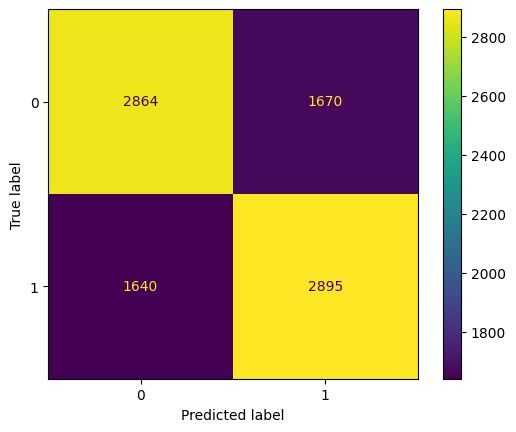

In [152]:
# confusion matrix
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
cm = confusion_matrix(y_test, model_tuned.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_tuned.classes_)
disp.plot()
plt.show()
